In [4]:
import os
import gc
import json
import torch
import datetime
import threading

import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import concurrent.futures
import statsmodels.api as sm
import matplotlib.pyplot as plt

from tqdm import tqdm
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

In [5]:
network_analytics = pd.read_csv('./data/Network_Analytics.csv')
series = pd.Series(network_analytics['OutboundUtilzation (%)'])

In [3]:
network_analytics.head()

,Timestamp,OutboundUtilzation (%)
0,10/10/2017 7:01,96.2442
1,10/10/2017 7:21,99.1131
2,10/10/2017 7:26,97.2892
3,10/10/2017 7:31,98.0286
4,10/10/2017 7:36,99.5263


[None, None, None, None, None, None, None, None]

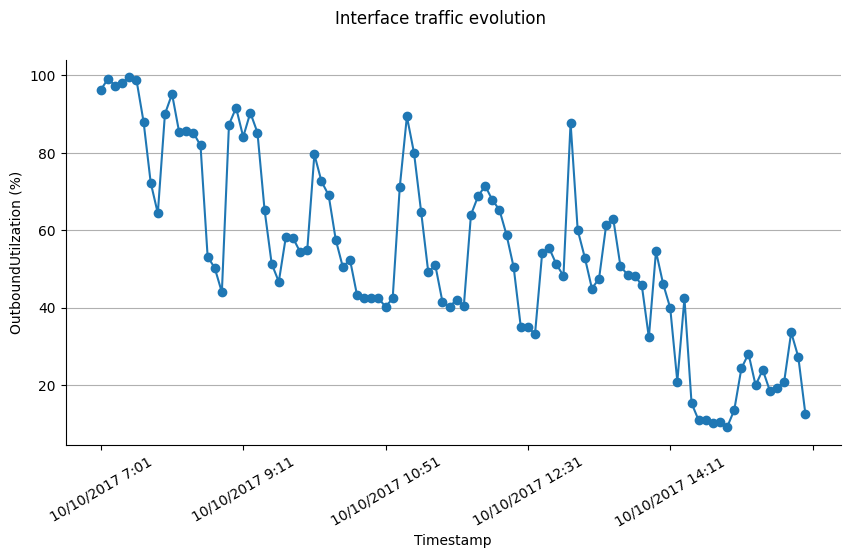

In [3]:
x = network_analytics['Timestamp'][:100]
y = network_analytics['OutboundUtilzation (%)'][:100]

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(x, y, marker='o')

fig.suptitle('Interface traffic evolution')
ax.set_ylabel('OutboundUtilzation (%)')
ax.set_xlabel('Timestamp')

ax.grid(True, axis='y')
ax.xaxis.set_major_locator(plt.MaxNLocator(6))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
[lab.set_rotation(30) for lab in ax.get_xticklabels()]

In [4]:
print(network_analytics['Timestamp'].max())
print(network_analytics['Timestamp'].min())
print(datetime.datetime.strptime(network_analytics['Timestamp'][len(network_analytics) - 1], '%d/%m/%Y %H:%M') - datetime.datetime.strptime(network_analytics['Timestamp'][0], '%d/%m/%Y %H:%M'))

12/9/2017 9:57
1/1/2018 0:02
295 days, 6:06:00


In [5]:
network_analytics.describe()

,OutboundUtilzation (%)
count,25631.000000
mean,60.372335
std,22.517275
min,0.000048
25%,44.873850
50%,62.100200
75%,77.702150
max,99.995500


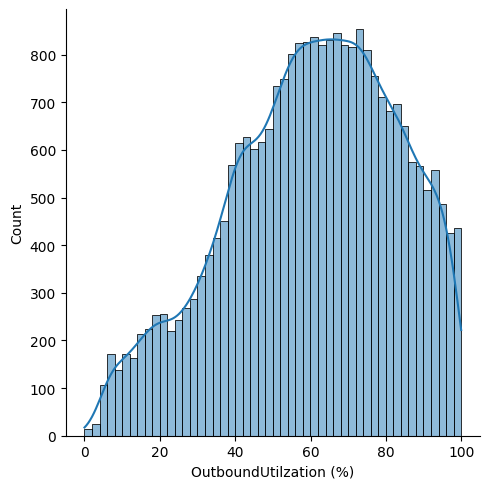

In [6]:
sns.displot(network_analytics['OutboundUtilzation (%)'], kde=True, bins=50)

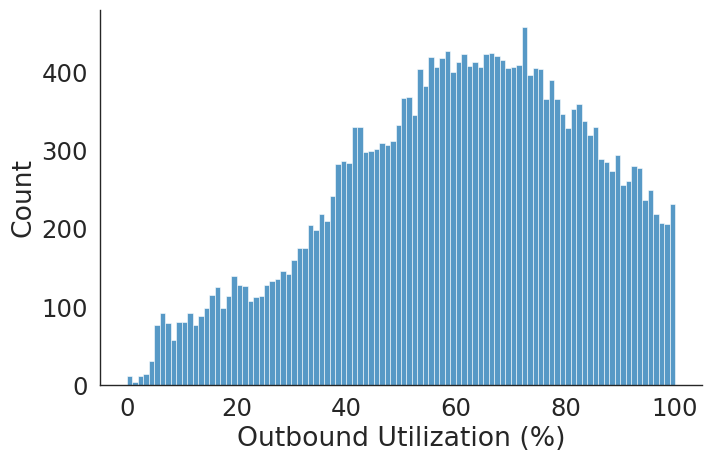

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions

network_analytics = pd.read_csv('./data/Network_Analytics.csv')
series = pd.Series(network_analytics['OutboundUtilzation (%)'])

sns.set_style('white')
sns.set_context("paper", font_scale = 2)
ax = sns.displot(data=network_analytics, x="OutboundUtilzation (%)", kind="hist", bins = 100, aspect = 1.5)
ax.set(
    xlabel='Outbound Utilization (%)'
)
plt.show()

2024-04-04 14:04:45.834 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED _fit distribution (taking more than 30 seconds)


2024-04-04 14:04:46.308 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.001389)
2024-04-04 14:04:46.877 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted anglit distribution with error=0.000821)
2024-04-04 14:04:47.017 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cosine distribution with error=0.000465)
2024-04-04 14:04:47.414 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted alpha distribution with error=0.157964)
2024-04-04 14:04:47.557 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted bradford distribution with error=0.002625)
2024-04-04 14:04:47.671 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted arcsine distribution with error=0.00556)
2024-04-04 14:04:47.705 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.007364)
2024-04-04 14:04:48.000 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted a

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
beta,0.000198,972.277862,1004.884093,0.011919,0.021277,1.641867e-10
genextreme,0.000206,981.610517,1006.065190,0.015800,0.020445,9.741908e-10
argus,0.000224,967.091038,991.545711,0.012977,0.027767,1.334904e-17
burr12,0.000269,990.353799,1022.960030,0.019518,0.026515,4.354192e-16
weibull_min,0.000288,989.621284,1014.075958,0.020731,0.025029,2.217850e-14


/home/ales/.cache/pypoetry/virtualenvs/data-science-ChFJ_N9T-py3.11/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/ales/.cache/pypoetry/virtualenvs/data-science-ChFJ_N9T-py3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


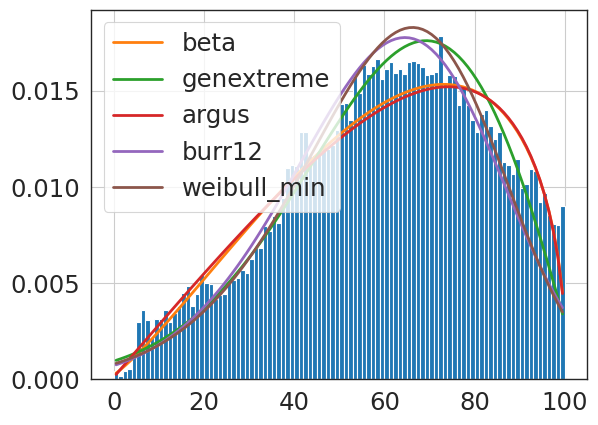

In [16]:
data = network_analytics['OutboundUtilzation (%)'].values

f = Fitter(data, distributions=get_distributions())
f.fit()
f.summary()

In [17]:
f.get_best(method = 'sumsquare_error')

{'beta': {'a': 2.2840246378455658,
  'b': 1.4660546616390748,
  'loc': -1.8357409964730569,
  'scale': 102.20562894315935}}

In [66]:
from scipy import stats

# d = scipy.stats.beta.fit(data)
# d
# stats.kstest(data, scipy.stats.beta.cdf())
dist = stats.beta.pdf(2.2840246378455658, 1.4660546616390748, -1.8357409964730569, 102.20562894315935)
stats.kstest(data, 'beta', (2.2840246378455658, 1.4660546616390748, -1.8357409964730569, 102.20562894315935))

KstestResult(statistic=0.021276993681405676, pvalue=1.6418667607936974e-10, statistic_location=75.5084, statistic_sign=1)

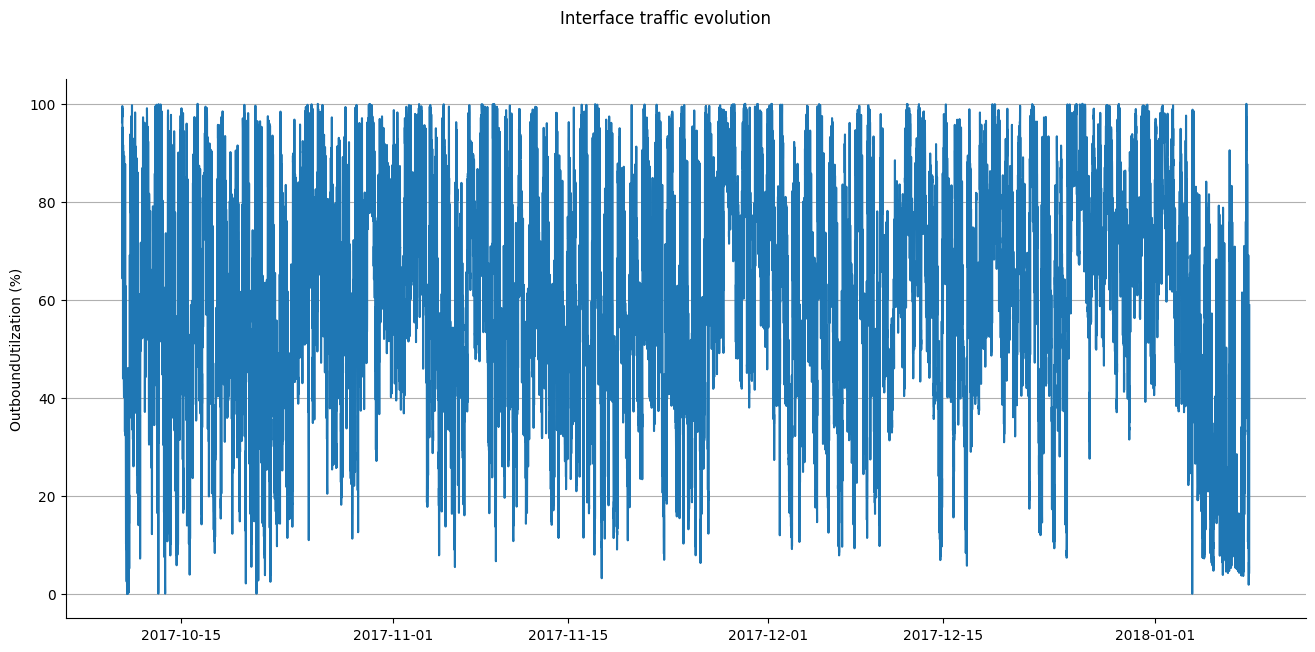

In [7]:
network_analytics['Timestamp']=pd.to_datetime(network_analytics['Timestamp'])
network_analytics_new = network_analytics.set_index('Timestamp')
network_analytics_new.rename(columns={'OutboundUtilzation (%)':'traffic_out'},inplace=True)  

x = network_analytics_new.index
y = network_analytics_new['traffic_out']

fig, ax = plt.subplots(figsize=(16, 7))

ax.plot(x, y)

fig.suptitle('Interface traffic evolution')
ax.set_ylabel('OutboundUtilzation (%)')

ax.grid(True, axis='y')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

/tmp/ipykernel_14988/2499562553.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  network_analytics_1H = network_analytics_new.resample('1H').mean()


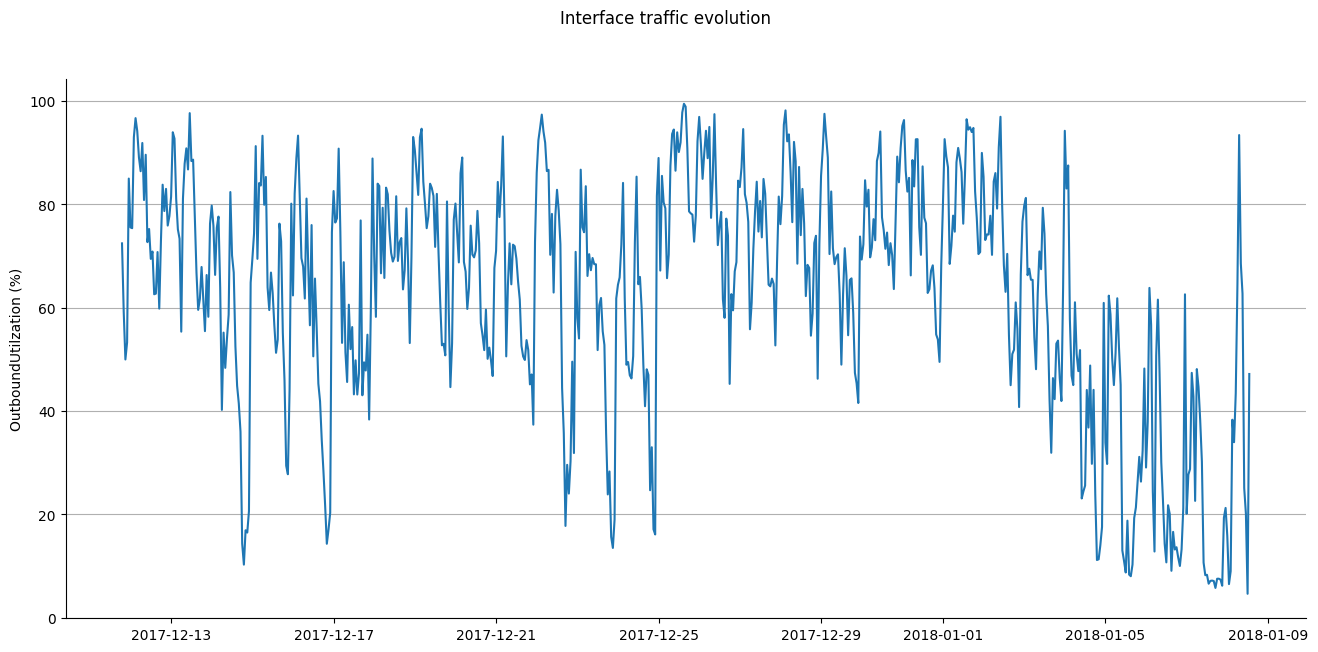

In [8]:
network_analytics_1H = network_analytics_new.resample('1H').mean()

x = network_analytics_1H.index[1500:]
y = network_analytics_1H[1500:]

fig, ax = plt.subplots(figsize=(16, 7))

ax.plot(x, y)

fig.suptitle('Interface traffic evolution')
ax.set_ylabel('OutboundUtilzation (%)')

ax.grid(True, axis='y')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

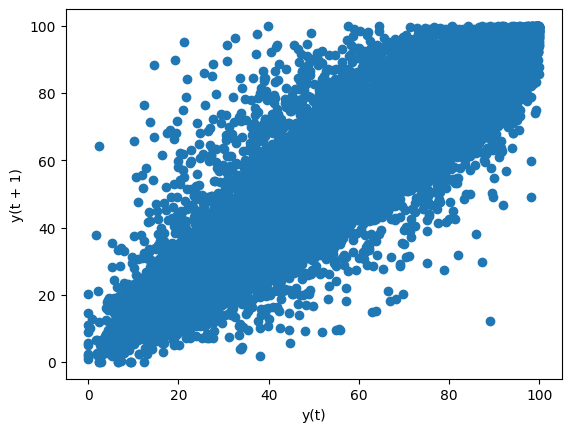

In [9]:
pd.plotting.lag_plot(series)

In [10]:
print(series.autocorr())

0.9229190122478933


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

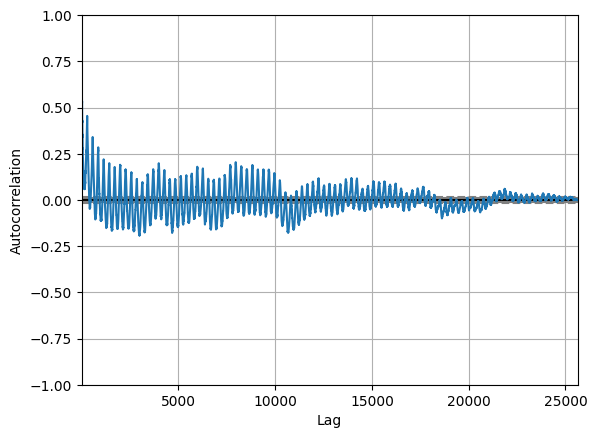

In [11]:
pd.plotting.autocorrelation_plot(series)

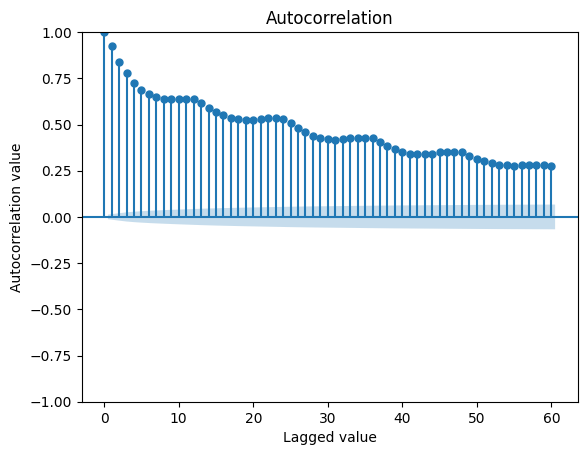

In [12]:
plot_acf(series, lags=60)
plt.ylabel("Autocorrelation value")
plt.xlabel("Lagged value")
plt.show()

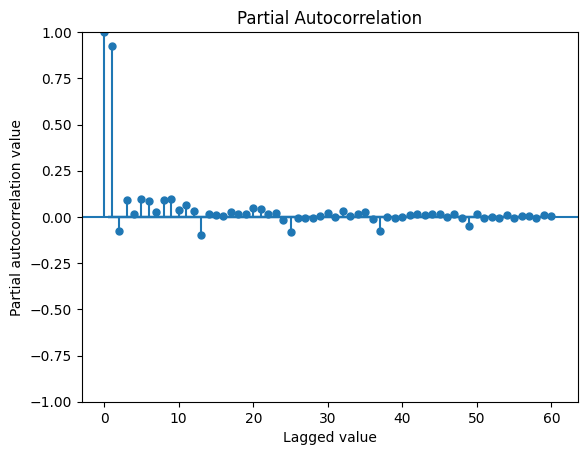

In [13]:
plot_pacf(series, lags=60)
plt.ylabel("Partial autocorrelation value")
plt.xlabel("Lagged value")
plt.show()

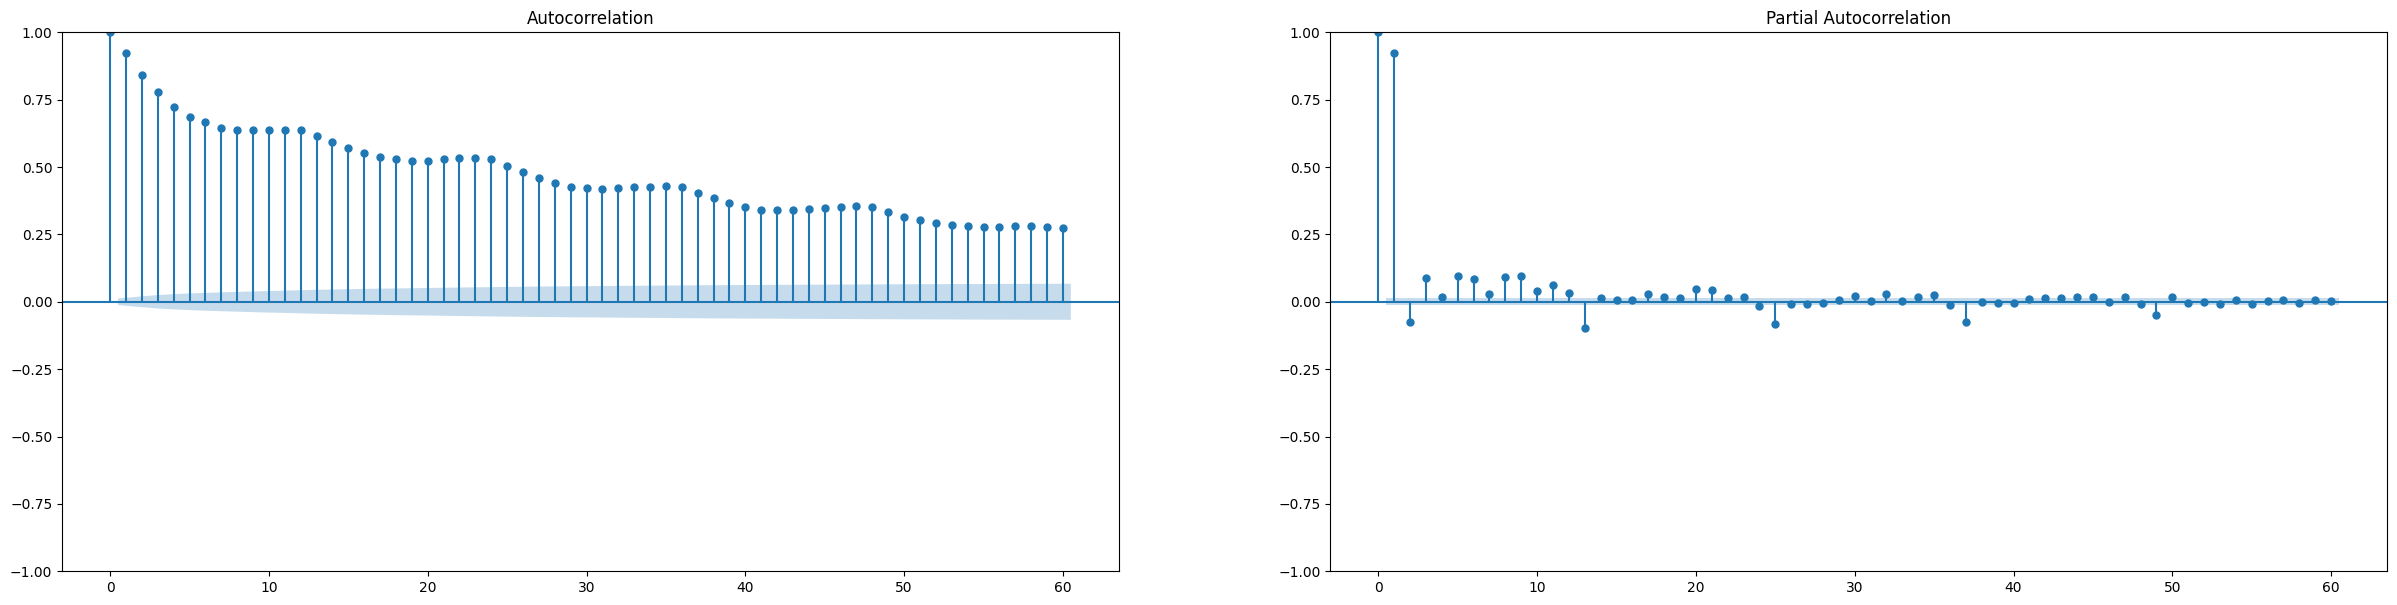

In [14]:
fig, ax = plt.subplots(1,2,figsize=(30,7))
sm.graphics.tsa.plot_acf(series, lags=60, ax=ax[0])
sm.graphics.tsa.plot_pacf(series, lags=60, ax=ax[1])
plt.show()

## Data preparation and utility function definition

In [136]:
def symmetric_mean_absolute_percentage_error(A, F):
    return 100/len(A) * np.sum(np.abs(F - A) / ((np.abs(A) + np.abs(F)) / 2))

In [137]:
def print_errors(usedlag, test, predictions, shape=True):
    if shape:
        test = test[:-1]
        predictions = predictions[1:]
    rmse = sqrt(mean_squared_error(test, predictions))
    print(f"RMSE for {usedlag} lagged values: {rmse}")

    mape = mean_absolute_percentage_error(test, predictions)
    print(f"MAPE for {usedlag} lagged values: {mape}")

    smape = symmetric_mean_absolute_percentage_error(test, predictions)
    print(f"SMAPE for {usedlag} lagged values: {smape}")

    mae = mean_absolute_error(test, predictions)
    print(f"MAE for {usedlag} lagged values: {mae}")

In [138]:
def plot_difference(test, predictions, dataset=network_analytics, shape=True):
    if shape:
        test = test[:-1]
        predictions = predictions[1:]
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(dataset.index[-100:], test[len(test)- 100:], color='g', label='ground truth')
    ax.plot(dataset.index[-100:], predictions[len(predictions) - 100:], color='r', label='predicted')
    plt.title('Difference between predicted and actual value')
    plt.xticks(dataset.index[-100::12])
    plt.legend(loc='best')
    plt.ylabel('OutboundUtilzation (%)')
    plt.xlabel('Timestamp')
    plt.show()

In [18]:
statistics, pval, ma_order, nobs, _, _ = adfuller(network_analytics['OutboundUtilzation (%)'], autolag='AIC')
if pval < 0.05:
    print(f"Data is stationary {statistics} {pval} {ma_order} {nobs}.")
else:
    print(f"Data is not stationary {statistics} {pval} {ma_order} {nobs}")

Data is stationary -12.704162687630898 1.0639878489318627e-23 49 25581.


In [19]:
X = series.values
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]

## MA model

In [ ]:
def worker_func(id : int):
    if id % 10 == 0:
        print(f"Processing {id} by thread {threading.get_native_id()}")
    model = ARIMA(endog=train, order=(0, 0, id))
    result = model.fit()
    aic = result.aic
    bic = result.bic
    residuals = result.resid
    result = acorr_ljungbox(residuals, lags=[id])
    p_value = result.iloc[0,1]
    return id, aic, bic, p_value

dir = 'output/information_criteria/MA'
for wrapp in range(6, 10):
    results = []
    with concurrent.futures.ThreadPoolExecutor(5) as executor:
        futures = {executor.submit(worker_func, (wrapp * 10) + x): x for x in range(1, 11)}
        for future in concurrent.futures.as_completed(futures):
            results.append(future.result())

    results = sorted(results, key=lambda x : x[0])

    with open(f"{dir}/MA_{wrapp}_criterions.json", 'w') as json_file:
        json.dump(results, json_file)

Selected Order (p): 52


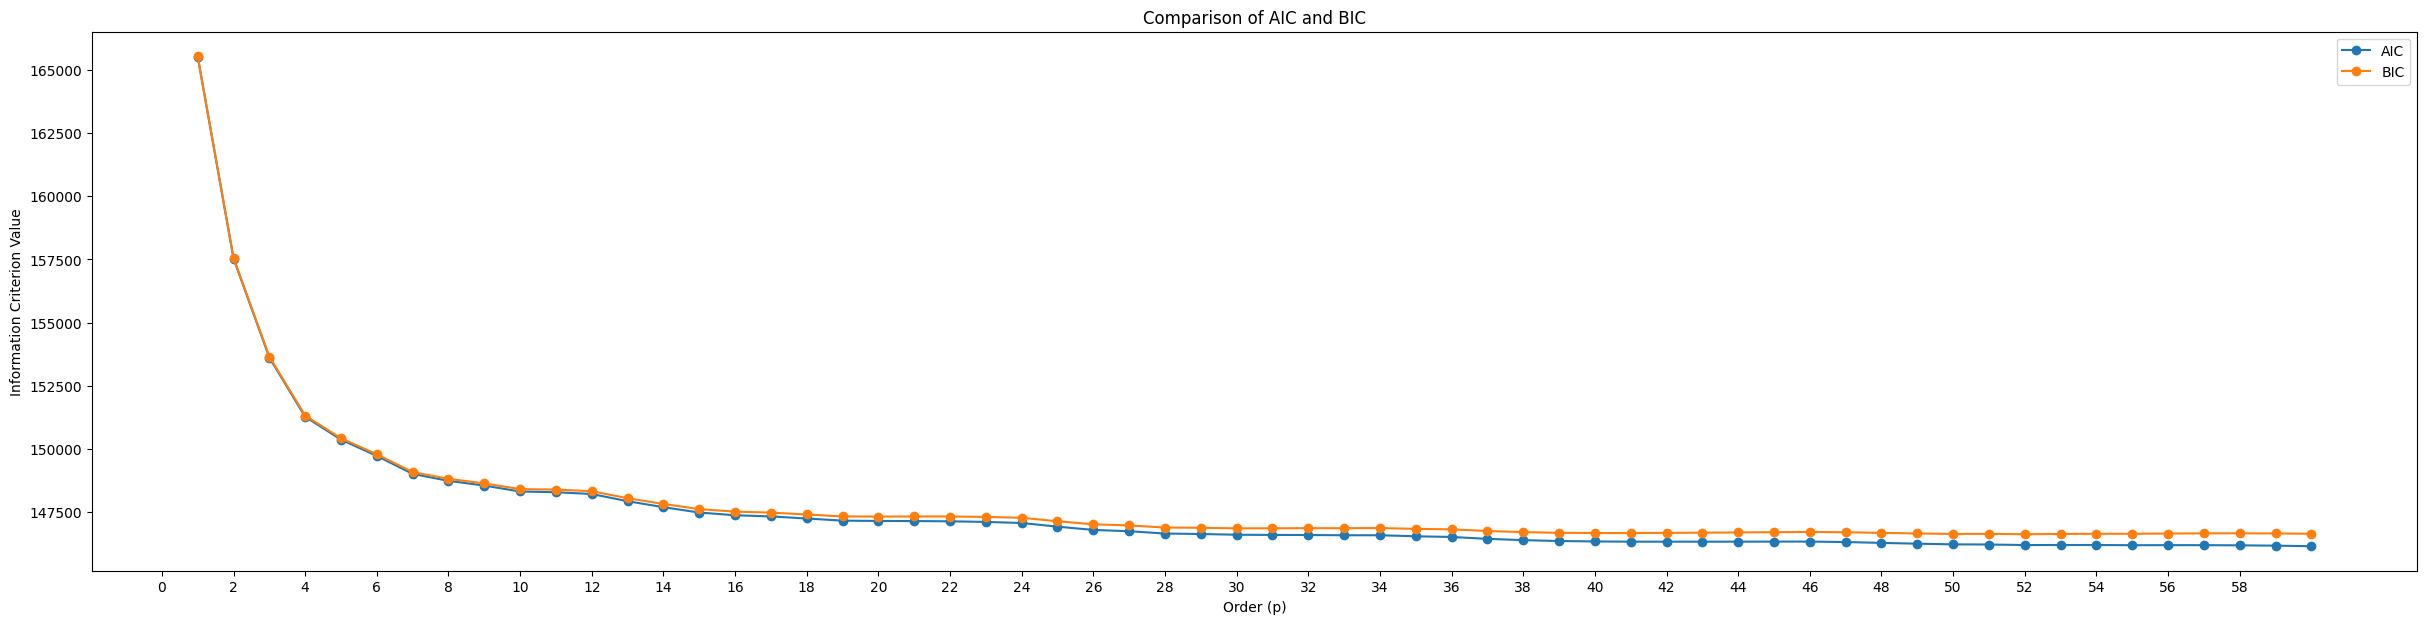

In [21]:
dir = 'output/information_criteria/MA/'

data = []
for file in os.listdir(dir):
    full_file_name = dir + file
    with open(full_file_name, 'r') as json_file:
        new_data = json.load(json_file)
    data.extend([dato for dato in new_data])
data = sorted(data, key=lambda x : x[0])
data = np.array(data)
aic_values = data[:,1]
bic_values = data[:,2]
p_values = data[:,3]

threshold = 0.05
ma_order = np.argmin(np.array(bic_values)) +  1
print("Selected Order (p):", ma_order)

plt.figure(figsize=(30,7))
plt.plot(range(1, len(data) + 1), aic_values, marker='o', label='AIC')
plt.plot(range(1, len(data) + 1), bic_values, marker='o', label='BIC')
plt.xlabel('Order (p)')
plt.ylabel('Information Criterion Value')
plt.title('Comparison of AIC and BIC')
plt.xticks(np.arange(0, len(data), 2.0))
plt.legend()
plt.show()

In [21]:
MA_model = ARIMA(endog=train, order=(0, 0, ma_order))
# if os.path.isfile('MA.pkl'):
#     results = ARIMAResults.load('MA.pkl')
# else:
results = MA_model.fit()

In [22]:
results.save('MA.pkl')

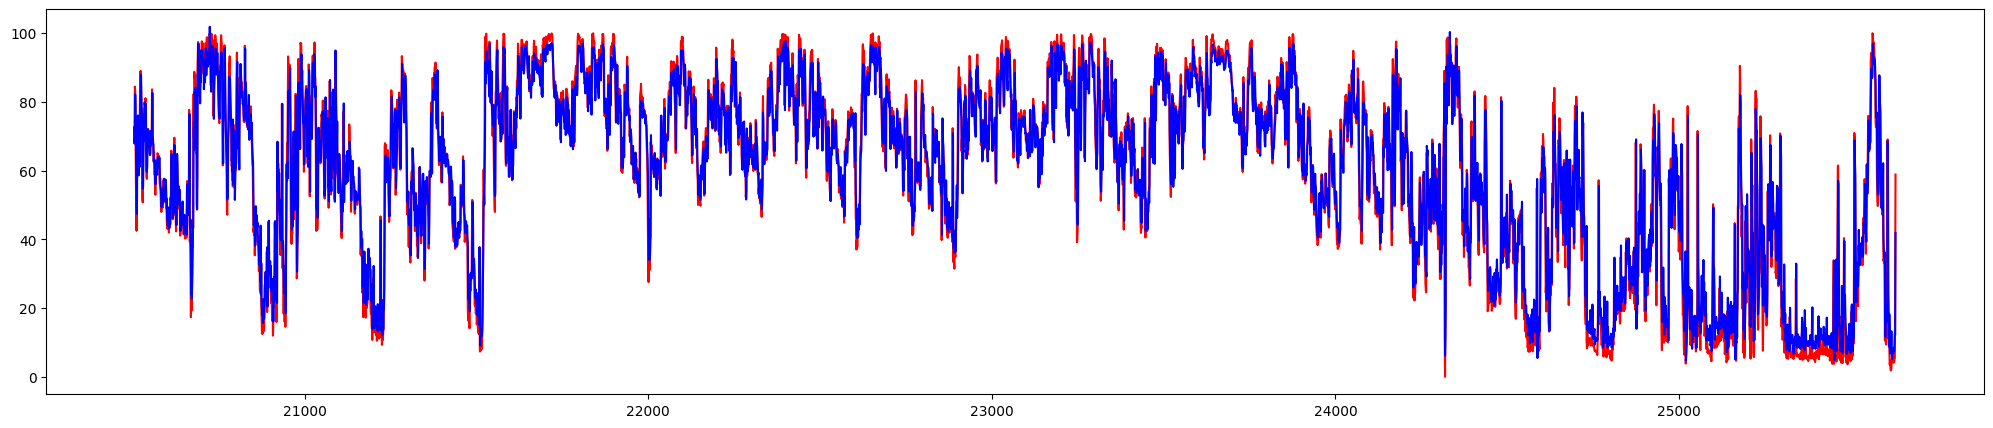

In [23]:
coef = results.params
# Grab last x values of the train dataset
history = train[len(train)-ma_order:]
# Compute their prediction
pred = results.predict(start=len(train) - ma_order + 1, end=len(train))
# Compute error between actual and prediction
errors = np.array(history - pred).tolist()

predictions = list()
for t in range(len(test)):
    yhat = coef[0]
    for d in range(ma_order):
        yhat += coef[d+1] * errors[ma_order-d-1]
        obs = X[t]
    predictions.append(yhat)

    errors.pop(0)
    errors.append(X[len(train) + t] - yhat)

fig, ax = plt.subplots(figsize=(25, 5))
ax.plot(range(size, len(network_analytics)),network_analytics['OutboundUtilzation (%)'][size:len(network_analytics)], color='r')
ax.plot(range(size, len(network_analytics)), predictions, color='b')

In [24]:
print_errors(ma_order, test, predictions)

RMSE for 49 lagged values: 3.0186189509161028
MAPE for 49 lagged values: 48.37084472443368
SMAPE for 49 lagged values: 7.757967502239647
MAE for 49 lagged values: 2.3884677826952103


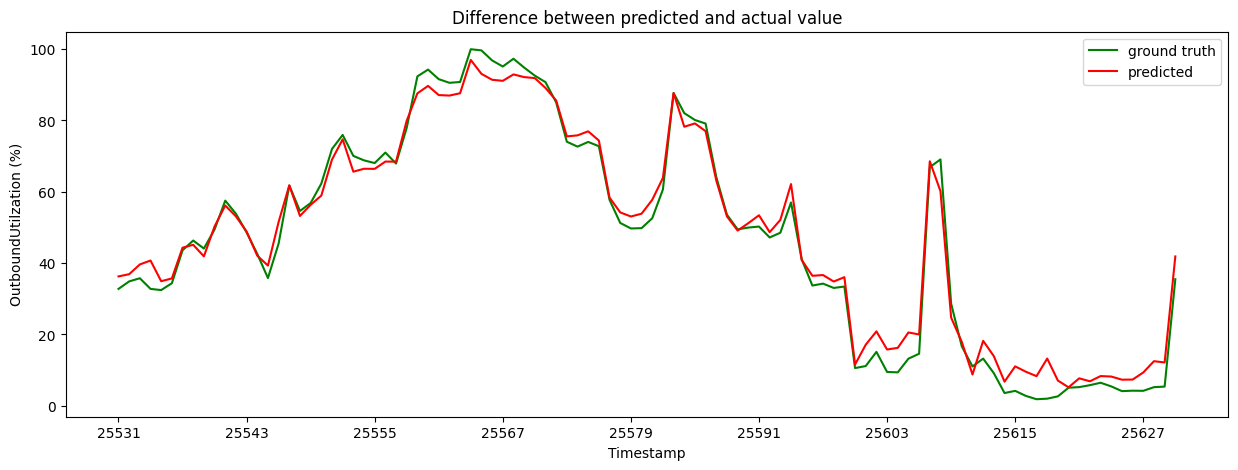

In [25]:
plot_difference(test, predictions)

## AR model

In [ ]:
def worker_func(id : int):
    if id % 10 == 0:
        print(f"Processing {id} by thread {threading.get_native_id()}")
    model = AutoReg(train, lags=id)
    result = model.fit()
    aic = result.aic
    bic = result.bic
    residuals = result.resid
    result = acorr_ljungbox(residuals, lags=[id])
    p_value = result.iloc[0,1]
    return id, aic, bic, p_value

dir = 'output/information_criteria/AR'
results = []
with concurrent.futures.ThreadPoolExecutor(5) as executor:
    futures = {executor.submit(worker_func, x): x for x in range(1, 500)}
    for future in concurrent.futures.as_completed(futures):
        results.append(future.result())

results = sorted(results, key=lambda x : x[0])

with open(f"{dir}/criterions.json", 'w') as json_file:
    json.dump(results, json_file)

Selected Order (p): 307


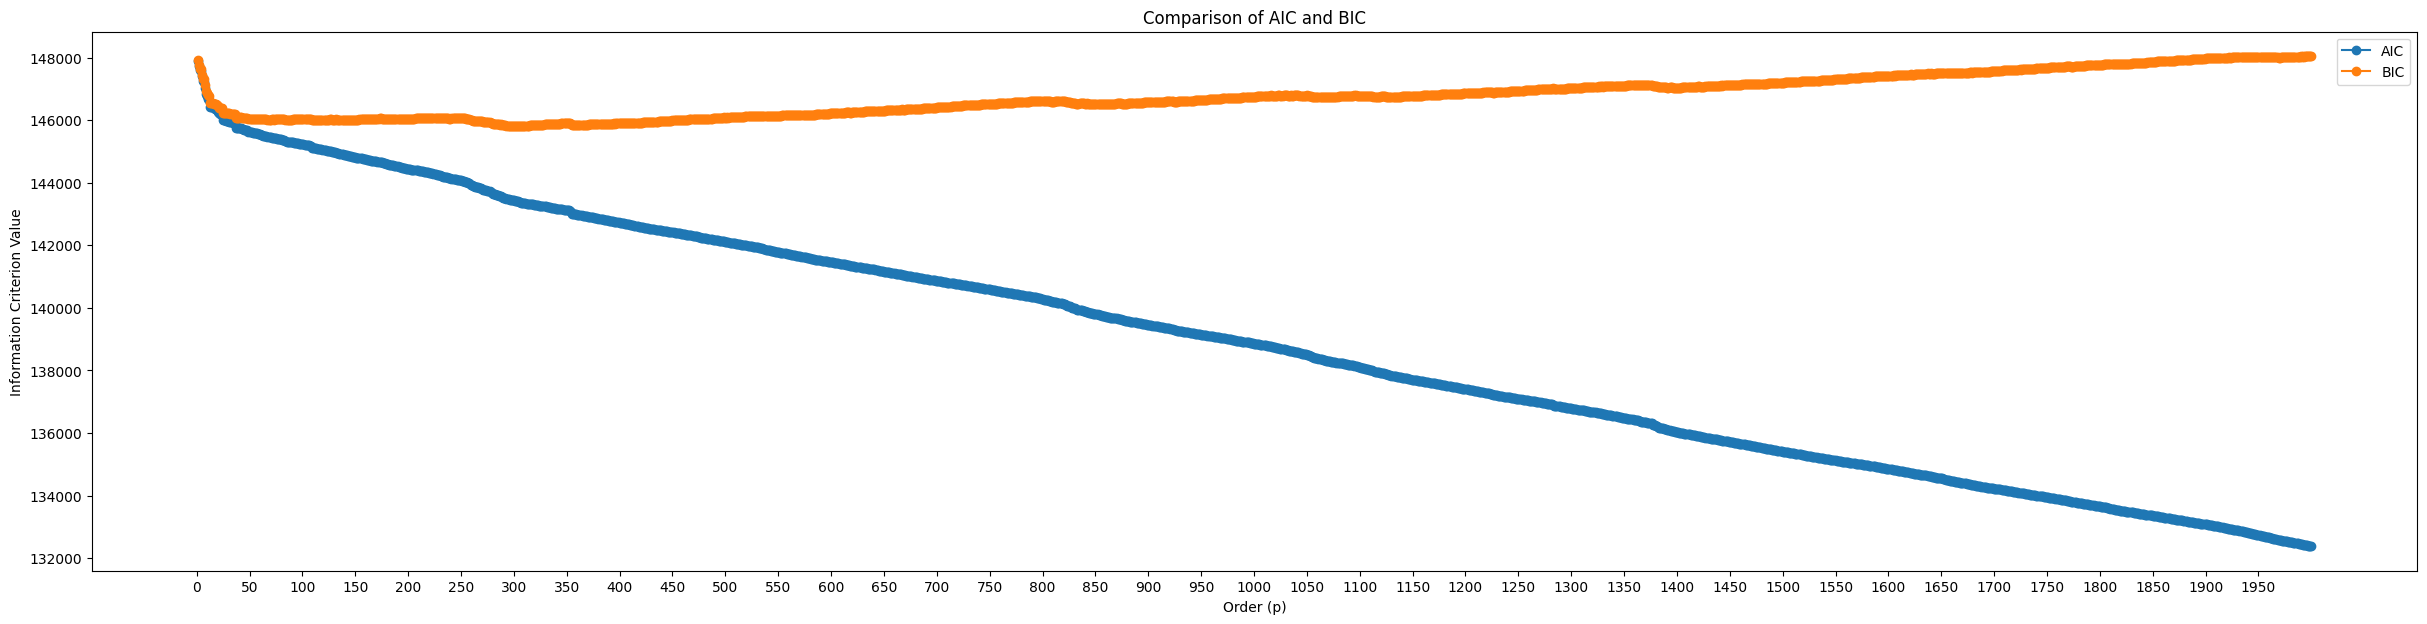

In [22]:
dir = 'output/information_criteria/AR'
with open(f"{dir}/criterion.json", 'r') as json_file:
    data = json.load(json_file)
data = sorted(data, key=lambda x : x[0])
data = np.array(data)
aic_values = data[:,1]
bic_values = data[:,2]
p_values = data[:,3]

ar_order = np.argmin(np.array(bic_values)) +  1
print("Selected Order (p):", ar_order)

plt.figure(figsize=(30,7))
plt.plot(range(1, len(data) + 1), aic_values, marker='o', label='AIC')
plt.plot(range(1, len(data) + 1), bic_values, marker='o', label='BIC')
plt.xlabel('Order (p)')
plt.ylabel('Information Criterion Value')
plt.title('Comparison of AIC and BIC')
plt.xticks(np.arange(0, len(data), 50.0))
plt.legend()
plt.show()

In [27]:
model = AutoReg(train, lags=ar_order)
model_fit = model.fit()
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-ar_order:].tolist()
predictions = list()
for t in range(len(test)):
    length = len(history)
    yhat = coef[0]
    for d in range(ar_order):
        yhat += coef[d+1] * history[d]
        obs = X[t]
    predictions.append(yhat)
    history.pop(0)
    history.append(obs)

In [28]:
print_errors(ar_order, test, predictions)

RMSE for 307 lagged values: 33.95919812585511
MAPE for 307 lagged values: 70.68416574663442
SMAPE for 307 lagged values: 54.26493632702288
MAE for 307 lagged values: 27.37264579807247


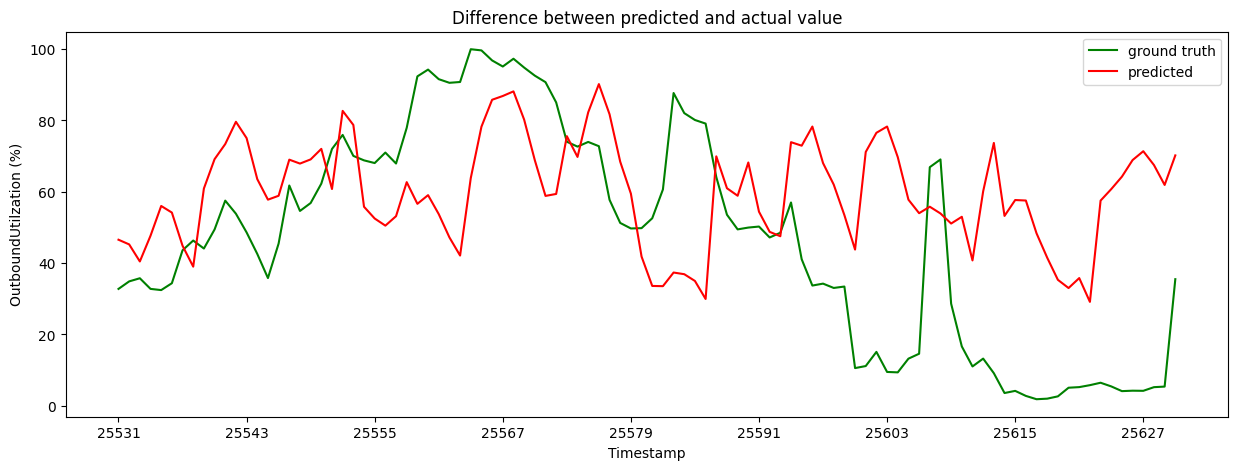

In [29]:
plot_difference(test, predictions)

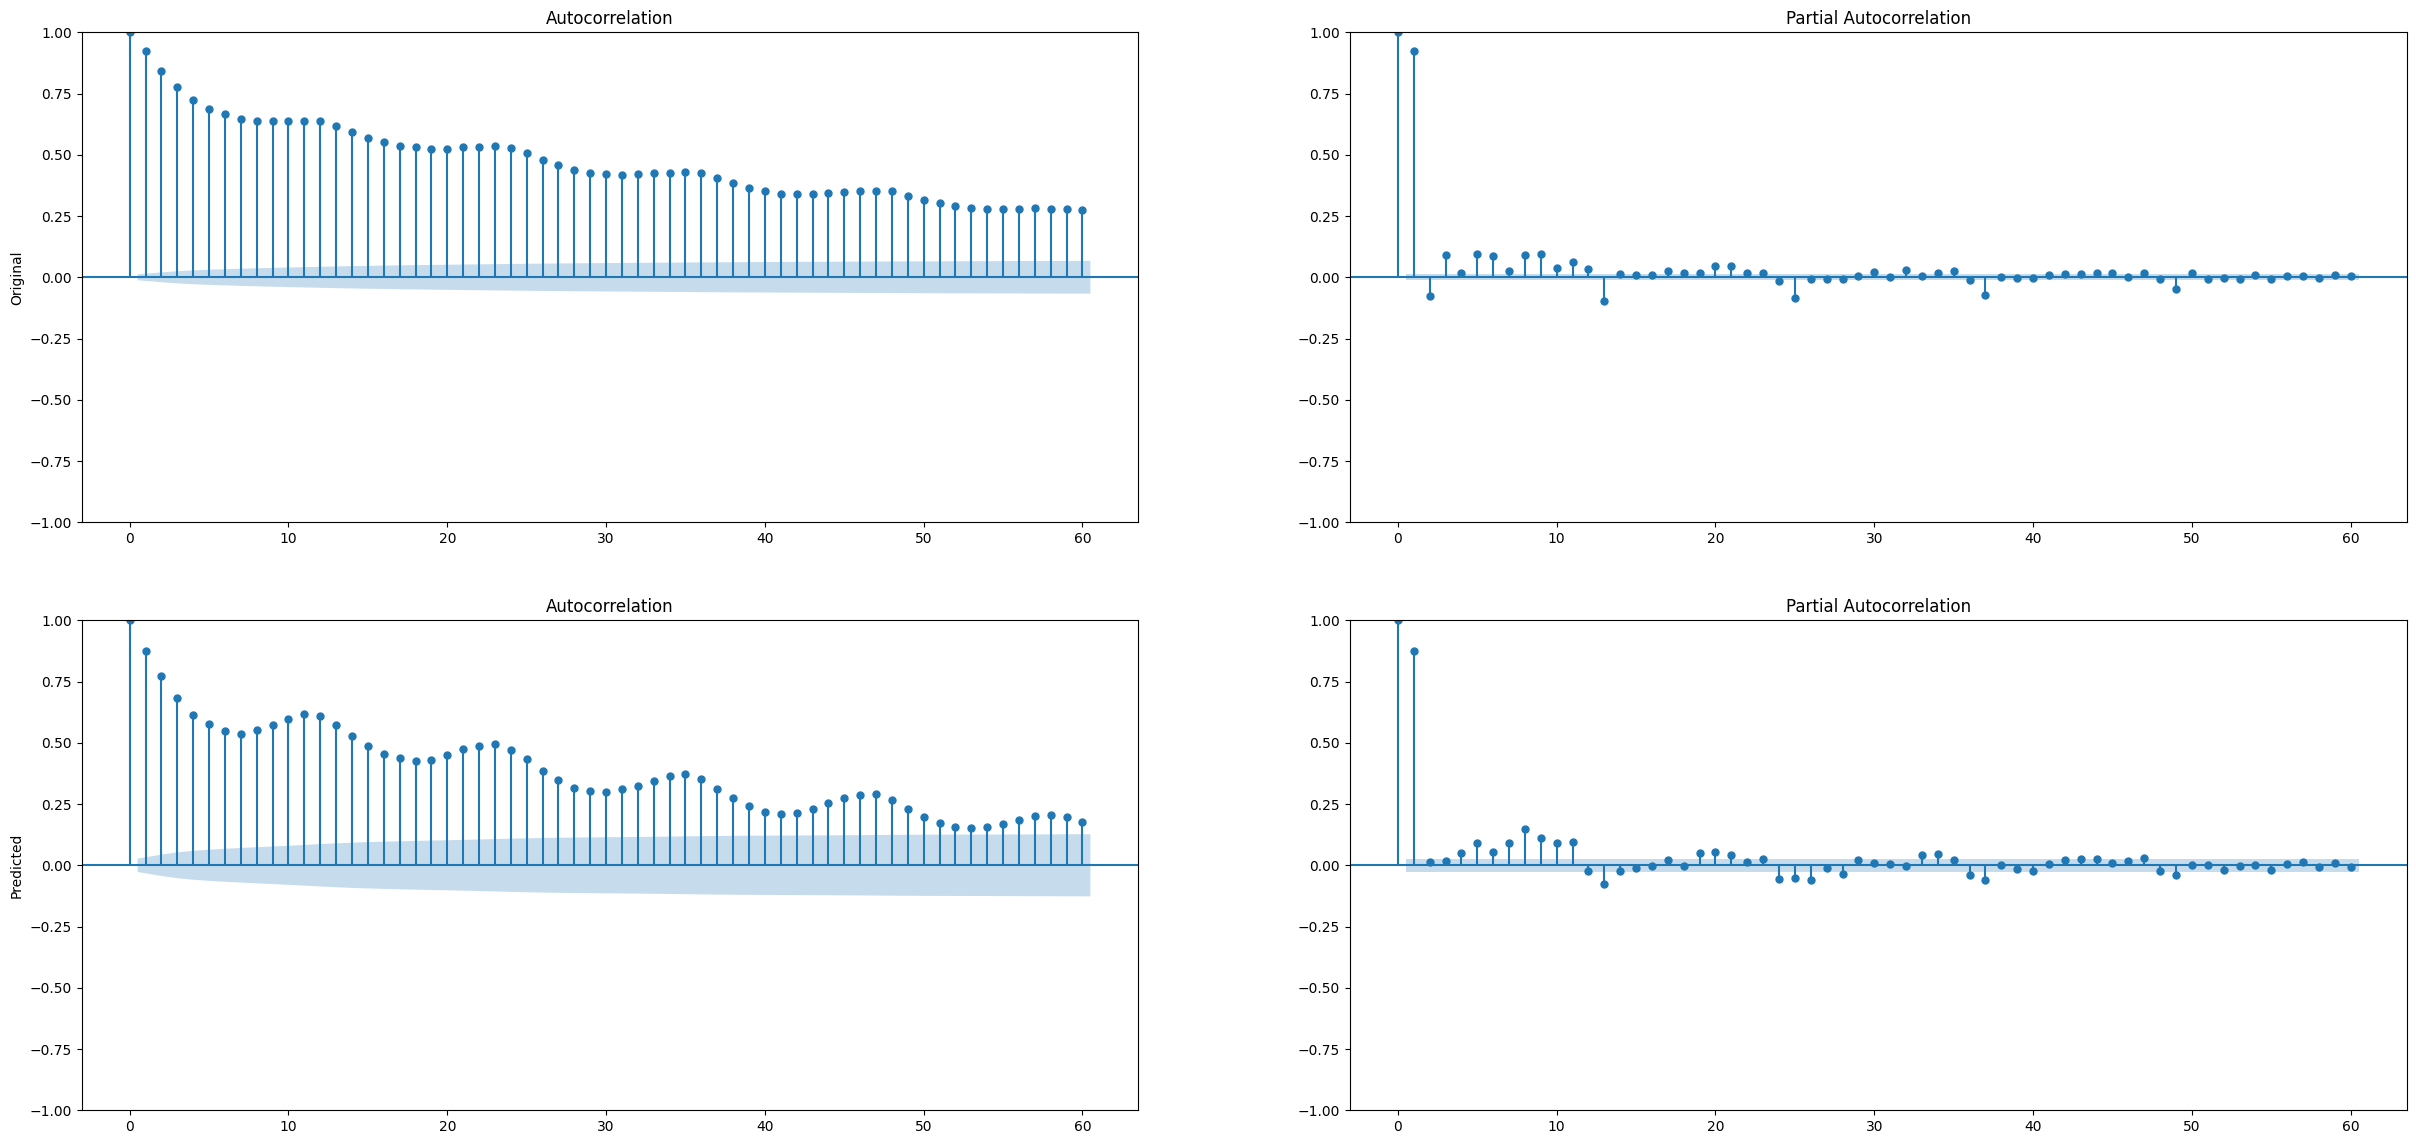

In [30]:
fig, ax = plt.subplots(2,2,figsize=(30,14))
sm.graphics.tsa.plot_acf(series, lags=60, ax=ax[0, 0])
sm.graphics.tsa.plot_pacf(series, lags=60, ax=ax[0, 1])
sm.graphics.tsa.plot_acf(predictions, lags=60, ax=ax[1, 0])
sm.graphics.tsa.plot_pacf(predictions, lags=60, ax=ax[1, 1])
ax[0, 0].set_ylabel("Original")
ax[1, 0].set_ylabel("Predicted")
plt.show()

## ARIMA

In [26]:
# network_analytics['Timestamp']=pd.to_datetime(network_analytics['Timestamp'])
# network_analytics = network_analytics.set_index('Timestamp')
# network_analytics_2H = network_analytics.resample('2H').mean()
# series = pd.Series(network_analytics_2H['OutboundUtilzation (%)'].values)

X = series.values
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]

In [23]:
print(f"{ar_order} {ma_order}")

307 52


In [32]:
# TODO fit arima

model = ARIMA(train, order=(ar_order, 0, ma_order))
model_fit = model.fit()

In [ ]:
model_fit.save('ARIMA_new.pkl')

In [ ]:
coef = model_fit.params
history = train[len(train)-ar_order:].tolist()

history_ma = train[len(train)-ma_order:].tolist()
pred = model_fit.predict(start=len(train) - ma_order + 1, end=len(train))
# Compute error between actual and prediction
errors = np.array(history_ma - pred).tolist()

predictions = list()
for t in range(len(test)):
    length = len(history)
    yhat = coef[0]
    for d in range(ar_order):
        yhat += coef[d+1] * history[d]

    for d in range(ma_order):
        yhat += coef[d+ar_order+1] * errors[ma_order-d-1]

    errors.pop(0)
    errors.append(test[t] - yhat)
    predictions.append(yhat)
    history.pop(0)
    history.append(test[t])

In [ ]:
print_errors(f"ARIMA({ar_order}, 0, {ma_order})", test, predictions)

In [ ]:
plot_difference(test, predictions)

## CNN

In [20]:
train_len = int(len(network_analytics) * 0.80)
valid_len = int(len(network_analytics) * 0.15)

train = network_analytics[:train_len]
valid = network_analytics[train_len:(train_len + valid_len)]
test = network_analytics[train_len + len(valid):]

assert len(network_analytics) == (len(train) + len(valid) + len(test))

print('Proportion of train_set : {:.2f}%'.format(len(train)/len(network_analytics) * 100))
print('Proportion of valid_set : {:.2f}%'.format(len(valid)/len(network_analytics) * 100))
print('Proportion of test_set : {:.2f}%'.format(len(test)/len(network_analytics) * 100))

Proportion of train_set : 80.00%
Proportion of valid_set : 15.00%
Proportion of test_set : 5.01%


In [21]:
def split_sequence(sequence, n_steps):
    x, y = list(), list()
    for i in range(len(sequence)):
        
        end_ix = i + n_steps
        
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x, dtype=np.float32), np.array(y, dtype=np.float32)

raw_seq = [10,20,30,40,50,60,70,80,90]
n_steps = 3
train_x,train_y = split_sequence(train['OutboundUtilzation (%)'].values,n_steps)
valid_x,valid_y = split_sequence(valid['OutboundUtilzation (%)'].values,n_steps)
test_x,test_y = split_sequence(test['OutboundUtilzation (%)'].values,n_steps)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class NetworkAnalyticsDataset(Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        
        return item, label
    
# https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8489399
class TimeseriesCNN(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super(TimeseriesCNN,self).__init__()

        self.conv1 = nn.Conv1d(3, 48, kernel_size=1)
        self.conv2 = nn.Conv1d(48, 96, kernel_size=1)

        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(96, 20)
        self.fc2 = nn.Linear(20, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.relu(x)

        x = x.view(-1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

In [22]:
model = TimeseriesCNN().to(device)
model.load_state_dict(torch.load('model200.pt', map_location=torch.device('cpu')))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()

In [24]:
train = NetworkAnalyticsDataset(train_x.reshape(train_x.shape[0],train_x.shape[1], 1), train_y)
valid = NetworkAnalyticsDataset(valid_x.reshape(valid_x.shape[0],valid_x.shape[1], 1), valid_y)
test = NetworkAnalyticsDataset(test_x.reshape(test_x.shape[0],test_x.shape[1], 1), test_y)

train_loader = DataLoader(train, batch_size=1, shuffle=False)
valid_loader = DataLoader(valid, batch_size=1, shuffle=False)
test_loader = DataLoader(test, batch_size=1, shuffle=False)

In [25]:
def train(loader : DataLoader):  
    running_loss = .0
    model.train()
    
    for idx, (inputs,labels) in enumerate(loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(inputs.float())
        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    train_loss = running_loss/len(loader)
    return train_loss.detach().cpu().numpy()
    
def validate(loader : DataLoader):
    running_loss = .0
    model.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            loss = criterion(preds,labels)
            running_loss += loss
            
        valid_loss = running_loss/len(loader)
        return valid_loss.detach().cpu().numpy()

def test(model, loader : DataLoader):
    running_loss = .0
    model.eval()
    predicted = []
    actuals = []
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            loss = criterion(preds,labels)
            running_loss += loss
            predicted.extend(preds.detach().cpu().numpy())
            actuals.extend(labels.detach().cpu().numpy())
            
        test_loss = running_loss/len(loader)
        return test_loss.detach().cpu().numpy(), np.array(predicted), np.array(actuals)

In [ ]:
epochs = 200

train_losses = []
valid_losses = []

for epoch in tqdm(range(epochs)):
    train_losses.append(train(train_loader))
    valid_losses.append(validate(valid_loader))
    gc.collect()

In [ ]:
plt.figure(figsize=(30,7))
plt.title('Loss evolution')
plt.plot(train_losses, marker='x', color='r', label='train loss')
plt.plot(valid_losses, marker='x', color='b', label='valid loss')
plt.show()
plt.legend(loc='best')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [28]:
model = TimeseriesCNN().to(device)
model.load_state_dict(torch.load("model200.pt", map_location=torch.device('cpu')))
model.eval()


loss, predictions, actuals = test(model, test_loader)
print_errors(f"CNN", actuals, predictions)

RMSE for CNN lagged values: 4.171446131689805
MAPE for CNN lagged values: 0.3322147727012634
SMAPE for CNN lagged values: 24.455551135530687
MAE for CNN lagged values: 3.7281014919281006


In [37]:
batch = next(iter(test_loader))
yhat = model(batch[0])

In [39]:
from torchviz import make_dot

make_dot(yhat, params=dict(list(model.named_parameters()))).render("rnn_torchviz", format="png")

'rnn_torchviz.png'

In [42]:
input_names = ['sequence']
output_names = ['prediction']
torch.onnx.export(model, batch[0], 'cnn.onnx', input_names=input_names, output_names=output_names)

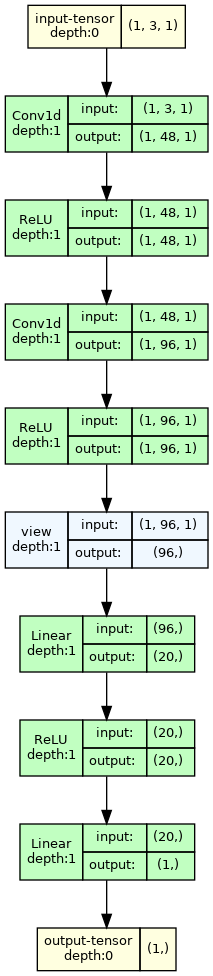

In [49]:
# from torchvision.utils import save_image
import graphviz
graphviz.set_jupyter_format('png')
from torchview import draw_graph

model_graph = draw_graph(model, input_size=(1,3,1), expand_nested=True)
model_graph.visual_graph
# save_image(model_graph.visual_graph, f'cnn_arch.png')

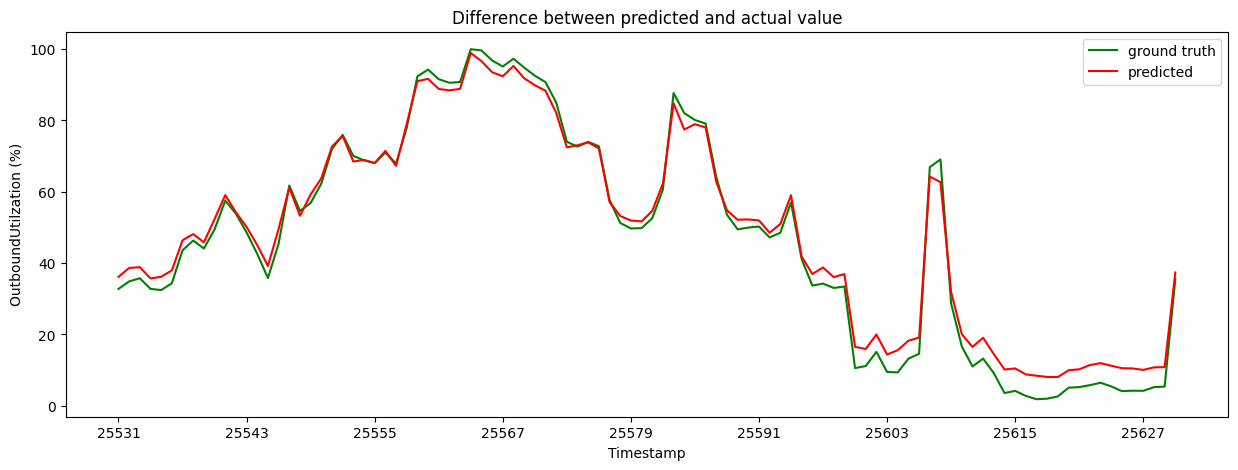

In [66]:
plot_difference(actuals, predictions)

In [54]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size) -> None:
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x : torch.Tensor):
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x

In [55]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X).to(device), torch.tensor(y).to(device)

In [56]:
df = pd.read_csv('./data/Network_Analytics.csv')
timeseries = df[["OutboundUtilzation (%)"]].values.astype('float32')

# train-test split for time series
train_size = int(len(timeseries) * 0.80)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [57]:
input_size = 1
hidden_size = 50
num_layers = 1
output_size = 1

X_train, y_train = create_dataset(train, lookback=hidden_size)
X_test, y_test = create_dataset(test, lookback=hidden_size)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

/tmp/ipykernel_19316/3808566825.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return torch.tensor(X).to(device), torch.tensor(y).to(device)


torch.Size([20454, 50, 1]) torch.Size([20454, 50, 1])
torch.Size([5077, 50, 1]) torch.Size([5077, 50, 1])


In [ ]:
learning_rate = 0.00001
num_epochs = 1000

model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
from copy import deepcopy

best_loss = np.inf
best_model = None

loader = DataLoader(TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

for epoch in range(num_epochs):
    model.train()
    for x, y in loader:
        y_pred = model(x)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(criterion(y_pred, y_train).detach().cpu())
        y_pred = model(X_test)
        test_rmse = np.sqrt(criterion(y_pred, y_test).detach().cpu())     

        if test_rmse < best_loss:
            print("Epoch %d: best RMSE %.4f, new RMSE %.4f" % (epoch, best_loss, test_rmse))
            best_loss = test_rmse
            best_model = deepcopy(model)


In [59]:
model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
model.load_state_dict(torch.load("best_lstm.pt", map_location=torch.device('cpu')))
model.eval()
y_pred = model(X_test).detach().cpu().numpy()
y_pred = y_pred[:, -1, :]
y_values = y_test.detach().cpu().numpy()[:, -1, :]

In [72]:
print_errors(f"LSTM", y_values, y_pred)

RMSE for LSTM lagged values: 3.233538828215406
MAPE for LSTM lagged values: 36.183197021484375
SMAPE for LSTM lagged values: 7.2702201921419425
MAE for LSTM lagged values: 2.2763991355895996


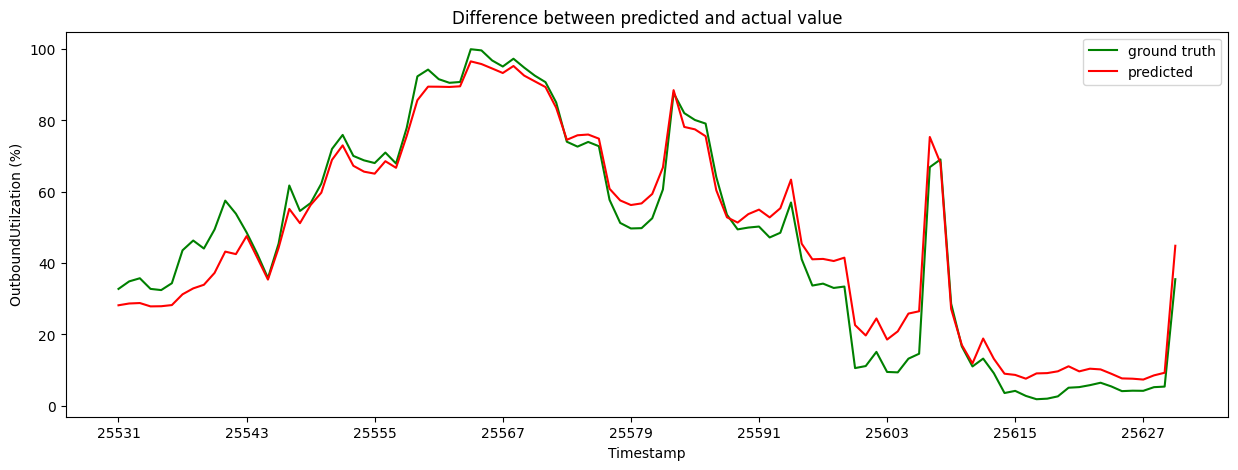

In [73]:
plot_difference(y_values, y_pred)

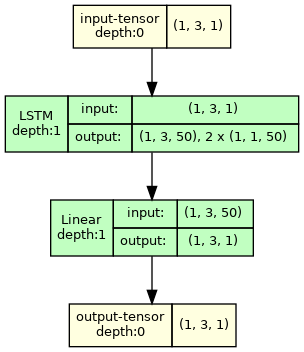

In [64]:
model_graph = draw_graph(model, input_size=(1,3,1), roll=True)
model_graph.visual_graph

In [2]:
from typing import Tuple

def load_data() -> Tuple[np.array, np.array]:
    data = pd.read_csv('data/Network_Analytics.csv')
    train, test = np.split(data, [int(.8*len(data))])
    
    train = train['OutboundUtilzation (%)'].values
    test = test['OutboundUtilzation (%)'].values
    
    train = np.array(train)
    test = np.array(test)

    return train, test


def prep_data(input_size, output_size):
    train, test = load_data()
    size_train = len(train) - output_size - input_size - 1
    size_test = len(test) - output_size - input_size - 1
    X_train = np.zeros((size_train, input_size, 1))
    Y_train = np.zeros((size_train, 1, input_size))
    
    X_test = np.zeros((size_test, input_size, 1))
    Y_test = np.zeros((size_test, 1, input_size))
    
    for i in range(size_train):
        start_in = i
        end_in = i + input_size
        
        start_trg = i + output_size
        end_trg = end_in + output_size
        x = np.reshape(train[start_in:end_in], (-1,1))
        y = train[start_trg:end_trg]
        X_train[i, :, :] = x
        Y_train[i, :, :] = y
        
    for i in range(size_test):
        start_in = i
        end_in = i + input_size
        
        start_trg = i + output_size
        end_trg = end_in + output_size
        
        x = np.reshape(test[start_in:end_in], (-1,1))
        y = test[start_trg:end_trg]

        X_test[i, :, :] = x
        Y_test[i, :, :] = y
        

    return X_train, Y_train, X_test, Y_test

In [27]:
from TCN import TCN

BATCH_SIZE = 32
LR = 0.0001
INPUT_SIZE = 32
OUTPUT_SIZE = 32
NUM_CHANNELS = [64, 32, 16, 8, 4, 2]
KERNEL_SIZE = 5
DROPOUT = .02
EPOCHS = 200

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_x, train_y, test_x, test_y = prep_data(INPUT_SIZE, 8)
train_x, train_y = torch.Tensor(train_x).to(device), torch.Tensor(train_y).to(device)
test_x, test_y = torch.Tensor(test_x).to(device), torch.Tensor(test_y).to(device)

train_loader = DataLoader(TensorDataset(train_x, train_y), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(TensorDataset(test_x, test_y), batch_size=BATCH_SIZE, shuffle=True)


model = TCN(INPUT_SIZE, OUTPUT_SIZE, NUM_CHANNELS, KERNEL_SIZE, DROPOUT).to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [28]:
from copy import deepcopy

best_loss = np.inf
best_model = None

model.train()
for epoch in tqdm(range(EPOCHS)):
    running_loss = .0
    model.train()

    for src, trg in train_loader:
        optimizer.zero_grad()
        preds = model(src)
        loss = criterion(preds, trg)
        loss.backward()
        optimizer.step()
        running_loss += loss

    train_loss = running_loss/len(train_loader)

    model.eval()
    with torch.no_grad():
        y_pred = model(train_x)
        train_rmse = criterion(y_pred, train_y).detach().cpu()
        y_pred = model(test_x)
        test_rmse = criterion(y_pred, test_y).detach().cpu()

        if test_rmse < best_loss:
            print("Epoch %d: best RMSE %.4f, new RMSE %.4f" % (epoch + 1, best_loss, test_rmse))
            best_loss = test_rmse
            best_model = deepcopy(model)

  0%|          | 1/200 [00:05<18:39,  5.63s/it]

Epoch 1: best RMSE inf, new RMSE 154.7589


  1%|          | 2/200 [00:11<18:29,  5.60s/it]

Epoch 2: best RMSE 154.7589, new RMSE 149.7610


  2%|▏         | 3/200 [00:16<18:29,  5.63s/it]

Epoch 3: best RMSE 149.7610, new RMSE 148.6330


  2%|▎         | 5/200 [00:28<18:10,  5.59s/it]

Epoch 5: best RMSE 148.6330, new RMSE 147.7434


  6%|▋         | 13/200 [01:12<17:18,  5.55s/it]

Epoch 13: best RMSE 147.7434, new RMSE 147.0630


 19%|█▉        | 38/200 [03:31<14:59,  5.55s/it]

Epoch 38: best RMSE 147.0630, new RMSE 146.9712


 32%|███▏      | 63/200 [05:49<12:40,  5.55s/it]

Epoch 63: best RMSE 146.9712, new RMSE 146.9317


 46%|████▌     | 92/200 [08:30<09:59,  5.55s/it]

Epoch 92: best RMSE 146.9317, new RMSE 146.9103


 48%|████▊     | 97/200 [08:58<09:35,  5.58s/it]

Epoch 97: best RMSE 146.9103, new RMSE 146.8415


 50%|█████     | 101/200 [09:21<09:13,  5.59s/it]

Epoch 101: best RMSE 146.8415, new RMSE 146.7835


 57%|█████▊    | 115/200 [10:39<07:54,  5.58s/it]

Epoch 115: best RMSE 146.7835, new RMSE 146.7798


 58%|█████▊    | 117/200 [10:50<07:45,  5.61s/it]

Epoch 117: best RMSE 146.7798, new RMSE 146.7680


 62%|██████▎   | 125/200 [11:35<06:59,  5.60s/it]

Epoch 125: best RMSE 146.7680, new RMSE 146.7613


 66%|██████▌   | 132/200 [12:14<06:20,  5.59s/it]

Epoch 132: best RMSE 146.7613, new RMSE 146.7322


 68%|██████▊   | 137/200 [12:42<05:56,  5.66s/it]

Epoch 137: best RMSE 146.7322, new RMSE 146.6459


 76%|███████▌  | 151/200 [14:06<04:58,  6.09s/it]

Epoch 151: best RMSE 146.6459, new RMSE 146.6448


 82%|████████▏ | 163/200 [15:18<03:40,  5.96s/it]

Epoch 163: best RMSE 146.6448, new RMSE 146.6076


100%|██████████| 200/200 [18:53<00:00,  5.67s/it]

Epoch 200: best RMSE 146.6076, new RMSE 146.6019


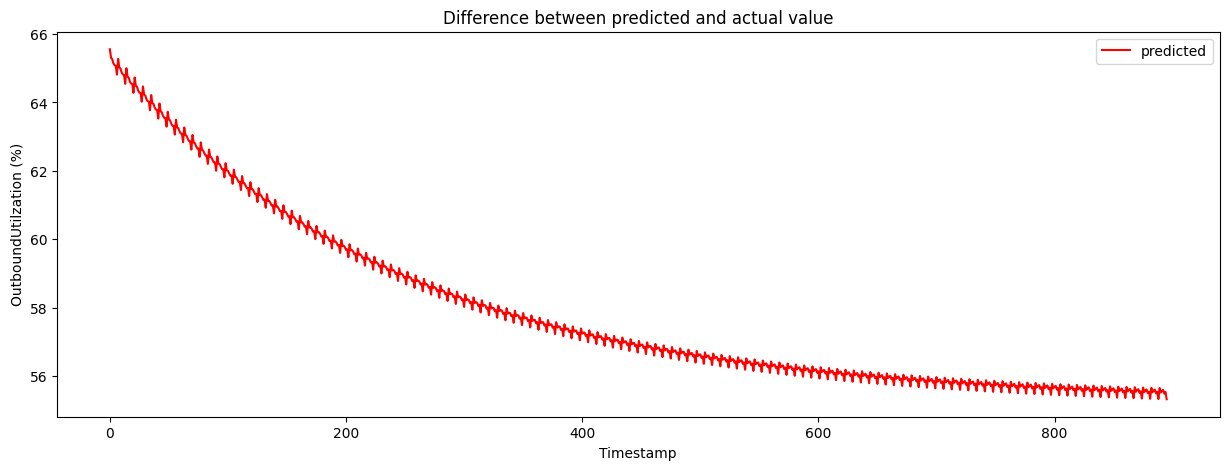

In [29]:
from copy import deepcopy

def forecast(model : nn.Module, start_series : torch.Tensor, prediction_len : int, forecast_values : int):
    prediction = []
    prediction_input = deepcopy(start_series)
    
    for x in range(0, forecast_values, prediction_len):
        yhat = model(prediction_input).squeeze(0)
        prediction.extend(yhat[0, len(yhat)-prediction_len:].detach().cpu().tolist())
        prediction_input = torch.reshape(yhat, (-1, 1)).unsqueeze(0)

    # print(start_series.shape)
    return prediction

TRAIN, TEST = load_data()
train = np.reshape(TRAIN[-32:], (-1, 1))

# best_model = TCN(INPUT_SIZE, OUTPUT_SIZE, NUM_CHANNELS, KERNEL_SIZE, DROPOUT).to(device)
# best_model.load_state_dict(torch.load('TCN.pt', map_location=device))
best_model.eval()
train_x, train_y, test_x, test_y = prep_data(32, 8)
# train_x[-1]
output = forecast(best_model, torch.Tensor(train).unsqueeze(0).to(device), 8, 1024)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(output, color='r', label='predicted')
plt.title('Difference between predicted and actual value')
plt.legend(loc='best')
plt.ylabel('OutboundUtilzation (%)')
plt.xlabel('Timestamp')
plt.show()

In [30]:
import darts

from darts import TimeSeries, concatenate
from darts.utils.callbacks import TFMProgressBar
from darts.models import TCNModel, RNNModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape, r2_score
from darts.utils.missing_values import fill_missing_values
from darts.datasets import AirPassengersDataset, SunspotsDataset, EnergyDataset

In [1]:
TRAIN, TEST = load_data()
network_analytics = pd.read_csv('./data/Network_Analytics.csv')
network_analytics['Timestamp'] = pd.to_datetime(network_analytics['Timestamp'])
network_analytics = network_analytics.set_index('Timestamp')
# network_analytics.drop_duplicates(inplace=True)

data = network_analytics.resample('Min').mean()
data = data.interpolate(method='linear', limit_direction='forward')
data = data.resample('5Min').mean()
# data.head()
ts = darts.TimeSeries.from_dataframe(data)
train, val = ts.split_after(pd.Timestamp("2017-12-21 08:42:00"))


NameError: name 'load_data' is not defined

In [119]:
scaler = Scaler()

train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
ts_scaled = scaler.transform(ts)

# We'll use the month as a covariate (scaling not required as one-hot-encoded)
month_series = datetime_attribute_timeseries(ts, attribute="month", one_hot=True)

In [131]:
model_name = "TCN_air"
model_air = TCNModel(
    input_chunk_length=13,
    output_chunk_length=12,
    n_epochs=100,
    dropout=0.1,
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=0,
    save_checkpoints=True,
    model_name=model_name,
    force_reset=True,
)

In [ ]:
model_air.fit(
    series=train_scaled,
    past_covariates=month_series,
    val_series=val_scaled,
    val_past_covariates=month_series,
)

In [133]:
backtest = model_air.historical_forecasts(
    series=ts_scaled,
    past_covariates=month_series,
    start=val_scaled.start_time(),
    forecast_horizon=6,
    retrain=False,
    verbose=True,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='time'>

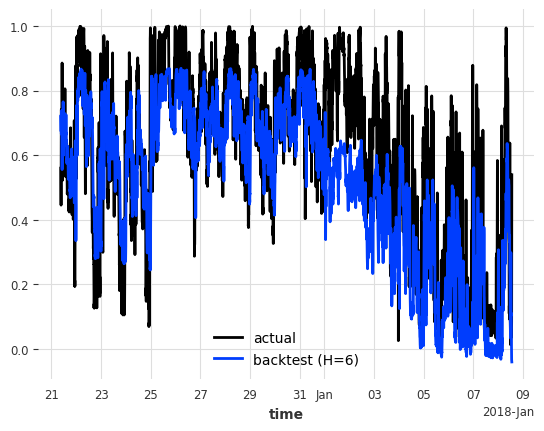

In [134]:
ts_scaled[len(ts_scaled) - len(backtest):].plot(label="actual")
backtest.plot(label="backtest (H=6)")

In [145]:
type(ts_scaled[len(ts_scaled) - len(backtest):].values())
len(ts_scaled[len(ts_scaled) - len(backtest):].values())
type(backtest.values())

numpy.ndarray

In [146]:
print_errors('TCNN', ts_scaled[len(ts_scaled) - len(backtest):].values(), backtest.values())

RMSE for TCNN lagged values: 0.1945950241784301
MAPE for TCNN lagged values: 0.3534435834231765
SMAPE for TCNN lagged values: 40.75446547967983
MAE for TCNN lagged values: 0.1504380571484153


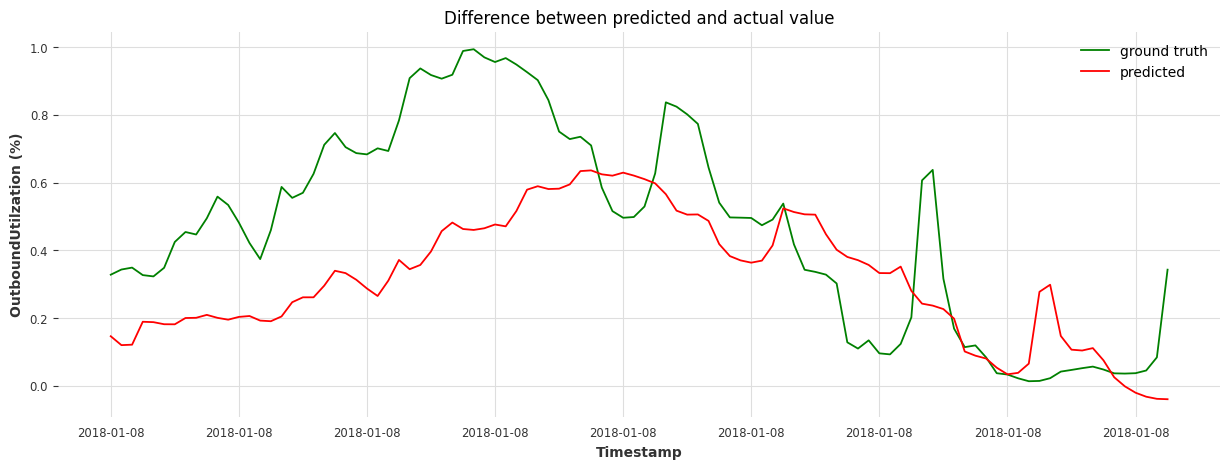

In [147]:
plot_difference(ts_scaled[len(ts_scaled) - len(backtest):].values(), backtest.values())

In [149]:
model_air.model

_TCNModule(
  (criterion): MSELoss()
  (train_metrics): MetricCollection,
    prefix=train_
  )
  (val_metrics): MetricCollection,
    prefix=val_
  )
  (dropout): MonteCarloDropout(p=0.1, inplace=False)
  (res_blocks): ModuleList(
    (0): _ResidualBlock(
      (dropout_fn): MonteCarloDropout(p=0.1, inplace=False)
      (conv1): Conv1d(13, 3, kernel_size=(5,), stride=(1,))
      (conv2): Conv1d(3, 3, kernel_size=(5,), stride=(1,))
      (conv3): Conv1d(13, 3, kernel_size=(1,), stride=(1,))
    )
    (1): _ResidualBlock(
      (dropout_fn): MonteCarloDropout(p=0.1, inplace=False)
      (conv1): Conv1d(3, 3, kernel_size=(5,), stride=(1,), dilation=(2,))
      (conv2): Conv1d(3, 1, kernel_size=(5,), stride=(1,), dilation=(2,))
      (conv3): Conv1d(3, 1, kernel_size=(1,), stride=(1,))
    )
  )
)